# 1. Install Dependencies and Setup

In [3]:
!pip install tensorflow


[notice] A new release of pip available: 22.3.1 -> 23.2
[notice] To update, run: pip install --upgrade pip


In [4]:
import tensorflow as tf
import os

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [7]:
import cv2
import imghdr

In [8]:
data_dir = 'data' 

In [9]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [10]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [11]:
import numpy as np
from matplotlib import pyplot as plt

In [48]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [49]:
data_iterator = data.as_numpy_iterator()

In [50]:
batch = data_iterator.next()

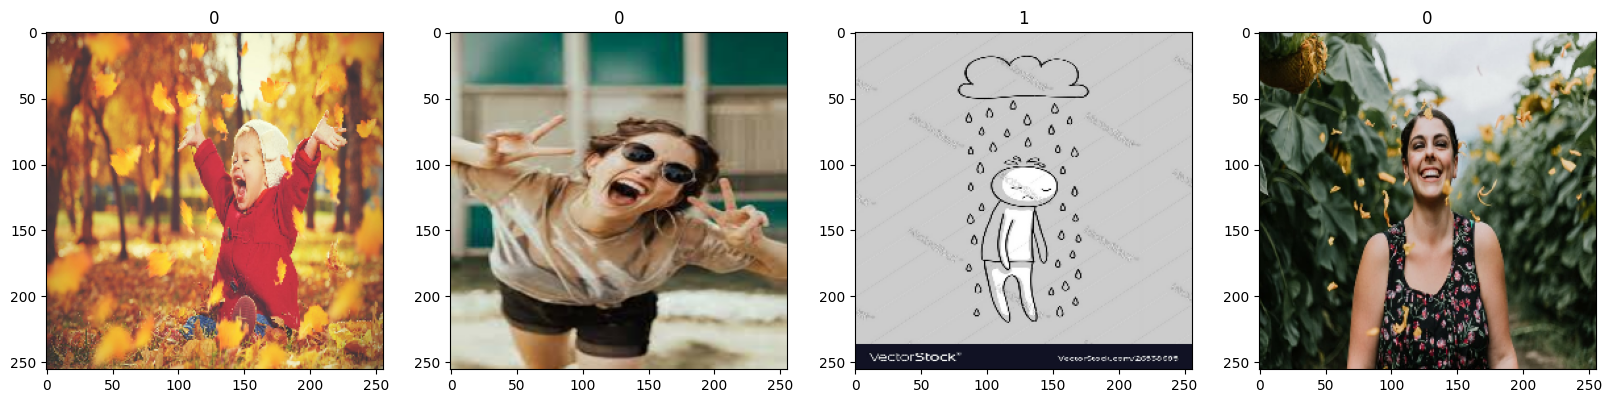

In [51]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [16]:
data = data.map(lambda x,y: (x/255, y))

In [17]:
data.as_numpy_iterator().next()

(array([[[[6.50980413e-01, 7.92156875e-01, 8.54901969e-01],
          [6.50980413e-01, 7.92493880e-01, 8.55912983e-01],
          [6.50980413e-01, 7.94025719e-01, 8.60508561e-01],
          ...,
          [2.48927698e-01, 3.54810059e-01, 4.37162995e-01],
          [2.47395828e-01, 3.53278190e-01, 4.35631126e-01],
          [2.47058824e-01, 3.52941185e-01, 4.35294122e-01]],
 
         [[6.54013455e-01, 7.94852912e-01, 8.58609080e-01],
          [6.53723836e-01, 7.94929266e-01, 8.59272540e-01],
          [6.52407408e-01, 7.95276344e-01, 8.62288415e-01],
          ...,
          [2.50436336e-01, 3.56318682e-01, 4.38671649e-01],
          [2.48772830e-01, 3.54655176e-01, 4.37008142e-01],
          [2.48406857e-01, 3.54289204e-01, 4.36642170e-01]],
 
         [[6.67800248e-01, 8.07107866e-01, 8.75459552e-01],
          [6.66194201e-01, 8.05999398e-01, 8.74543309e-01],
          [6.58893883e-01, 8.00961018e-01, 8.70378554e-01],
          ...,
          [2.57293820e-01, 3.63176167e-01, 4.4552

# 5. Split Data

In [18]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [19]:
train_size

7

In [20]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [21]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [23]:
model = Sequential()

In [24]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [25]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

# 7. Train

In [27]:
logdir='logs'

In [28]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [29]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 5s 488ms/step - loss: 0.8993 - accuracy: 0.4955 - val_loss: 0.6363 - val_accuracy: 0.5156
Epoch 2/20
7/7 [==============================] - 5s 520ms/step - loss: 0.6814 - accuracy: 0.6250 - val_loss: 0.6061 - val_accuracy: 0.8438
Epoch 3/20
7/7 [==============================] - 5s 534ms/step - loss: 0.5642 - accuracy: 0.7411 - val_loss: 0.4734 - val_accuracy: 0.7656
Epoch 4/20
7/7 [==============================] - 5s 572ms/step - loss: 0.4108 - accuracy: 0.8348 - val_loss: 0.2133 - val_accuracy: 0.9219
Epoch 5/20
7/7 [==============================] - 5s 540ms/step - loss: 0.3421 - accuracy: 0.8705 - val_loss: 0.4245 - val_accuracy: 0.7344
Epoch 6/20
7/7 [==============================] - 5s 538ms/step - loss: 0.3104 - accuracy: 0.8750 - val_loss: 0.1985 - val_accuracy: 0.9688
Epoch 7/20
7/7 [==============================] - 5s 494ms/step - loss: 0.1752 - accuracy: 0.9554 - val_loss: 0.1990 - val_accuracy: 0.9062
Epoch 8/20
7/7 [====

# 8. Plot Performance

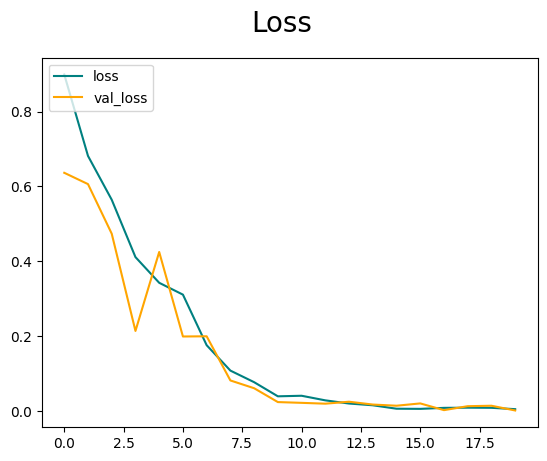

In [30]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

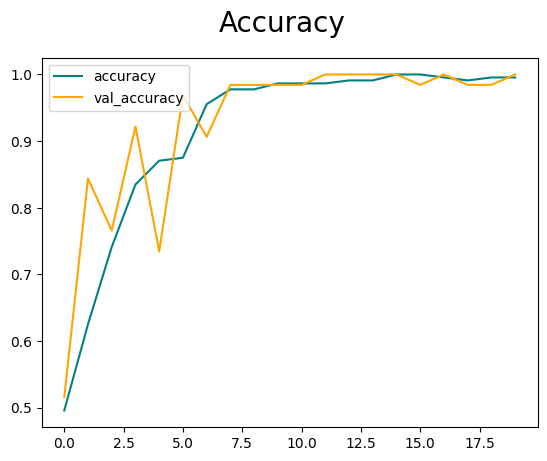

In [31]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [32]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [33]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [34]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 86ms/step


In [35]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [36]:
import cv2

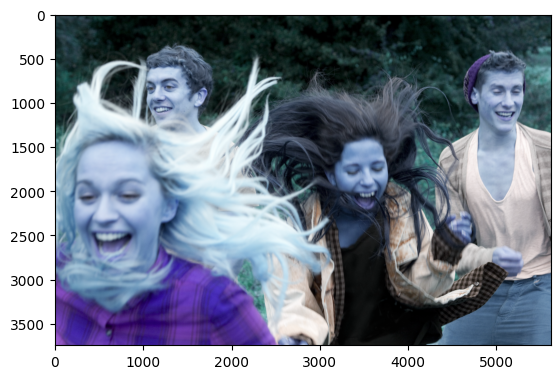

In [37]:
img = cv2.imread('154006829.jpg')
plt.imshow(img)
plt.show()

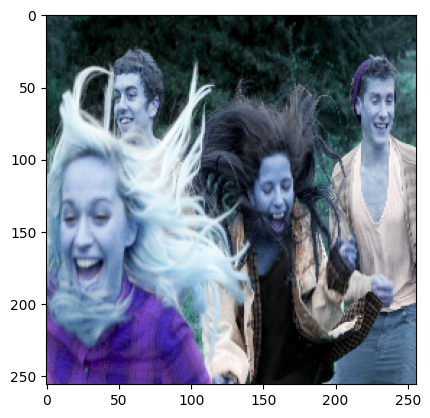

In [38]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [39]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 14ms/step


In [40]:
yhat

array([[0.03155535]], dtype=float32)

In [41]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [42]:
from tensorflow.keras.models import load_model

In [43]:
model.save(os.path.join('models','imageclassifier.h5'))

/Users/riccardo/Desktop/Repositorys_Github/Deep_learning_fund/ImageClassification/imageclassfication/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [44]:
new_model = load_model('imageclassifier.h5')

OSError: No file or directory found at imageclassifier.h5

In [45]:
new_model.predict(np.expand_dims(resize/255, 0))

NameError: name 'new_model' is not defined